In [87]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

### Loading Dataset

In [88]:
# ImageNet normalization values
mean_img_net = np.array([0.485, 0.456, 0.406])
std_img_net = np.array([0.229, 0.224, 0.225])

image_transforms=transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),                                                       # Convert images to PyTorch tensors
    transforms.Normalize(mean=mean_img_net, std=std_img_net)  # Normalize to range [-1, 1]
])

In [89]:
data = datasets.ImageFolder(root= ".\dataset",transform= image_transforms)

In [90]:
len(data)

6862

In [91]:
clasess = data.classes
clasess

['dew',
 'fogsmog',
 'frost',
 'glaze',
 'hail',
 'lightning',
 'rain',
 'rainbow',
 'rime',
 'sandstorm',
 'snow']

In [102]:
num_classes = len(clasess)
num_classes

11

### Visualizing the dataset

In [92]:
#denomalizing the images for visualization
def denormalize(img_tensor):
    img = img_tensor.permute(1, 2, 0).numpy()  # Convert [C, H, W] -> [H, W, C]
    img = std_img_net * img + mean_img_net     # Denormalize
    img = np.clip(img, 0, 1)                   # Clip to [0,1] for display
    return img

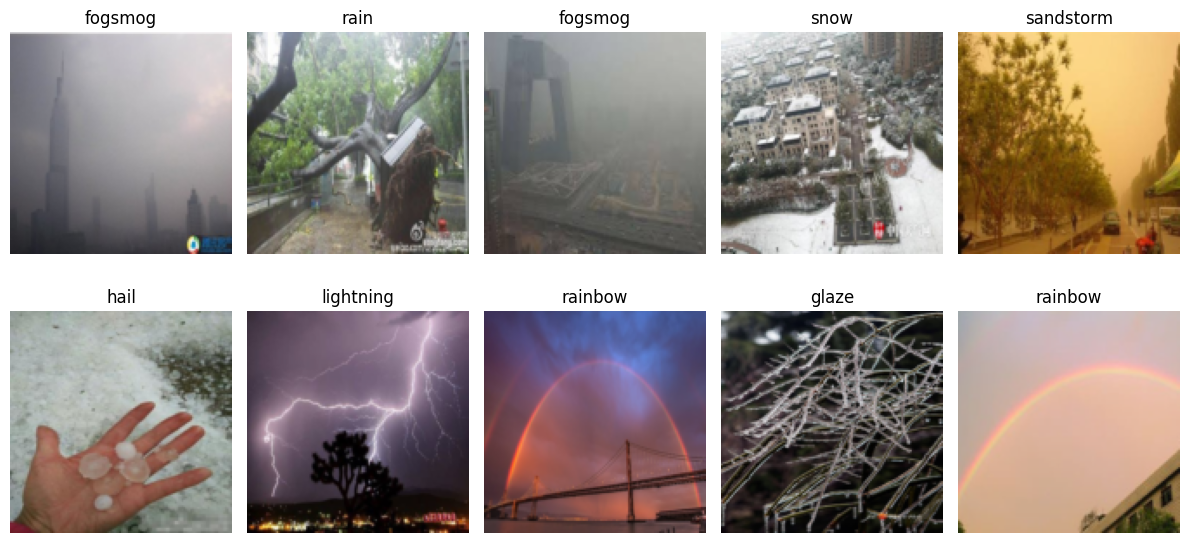

In [93]:
# Full dataset (ImageFolder)
num_images = 10
ncols = 5
nrows = int(np.ceil(num_images / ncols))

random_sampled_indices = np.random.randint(0, len(data) - 1, num_images)

plt.figure(figsize=(12, 3 * nrows))
for i in range(num_images):
    image, label = data[random_sampled_indices[i]]  # Get image and label
    img = denormalize(image)

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(img)
    plt.title(clasess[label])  # Assuming clasess is the class name list
    plt.axis("off")

plt.tight_layout()

## Splitting into train and test 

In [94]:
train_size = int(0.8 * len(data))  # 80% for training
test_size = len(data) - train_size  # 20% for testing
train_data, test_data = random_split(data, [train_size, test_size])

In [95]:
len(train_data), len(test_data)

(5489, 1373)

In [96]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [100]:
for i,(image,label) in enumerate(train_loader):
    print(image.shape)
    break

torch.Size([32, 3, 128, 128])


## Building Convolution Neural Network and predicting

In [105]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        
        # Input assumed to be [B, 3, 128, 128]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2)

        # Output size after conv & pool depends on input size. For 128×128 input:
        # Conv1: 128 → 128
        # Conv2: 128 → 128
        # Pool: 128 → 64
        self.flattened_size = 32 * 64 * 64

        self.fc1 = nn.Linear(self.flattened_size, 100)
        self.dropout2 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))   # [B, 32, 128, 128]
        x = F.relu(self.conv2(x))   # [B, 32, 128, 128]
        x = self.pool(x)            # [B, 32, 64, 64]
        #x = self.dropout1(x)

        x = x.view(x.size(0), -1)   # Flatten → [B, 32×64×64]
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x                    # Raw logits; apply softmax during loss eval if needed


In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [107]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Accuracy = {acc:.2f}%")


Epoch 1: Loss = 268.9422, Accuracy = 51.94%
Epoch 2: Loss = 160.0130, Accuracy = 69.59%
Epoch 3: Loss = 105.2461, Accuracy = 80.21%
Epoch 4: Loss = 60.2725, Accuracy = 88.12%
Epoch 5: Loss = 40.8921, Accuracy = 92.48%
Epoch 6: Loss = 28.6512, Accuracy = 94.39%
Epoch 7: Loss = 22.6908, Accuracy = 95.74%
Epoch 8: Loss = 19.2968, Accuracy = 96.37%
Epoch 9: Loss = 13.4320, Accuracy = 97.70%
Epoch 10: Loss = 14.3943, Accuracy = 97.52%


In [112]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 67.88%
